<span style="font-size:200%">Merk: denne notebooken er bare for dokumentasjon/planleggning. Skal live-kodes.</span>

# Plan

Mål: Hands-on illustrasjon (med det fremste av rammeverk og teknologi) av «deep learning-revolusjonen»

1. Les inn CIFAR10-data. Plot og utforsk. 
2. Sett opp enkelt, gammeldags NN i Pytorch (et layer, uten dropout, med tanh etc).
3. Bytt til Keras (for mindre skriving). Sett opp samme nett i Keras. Tren og test dette.
4. Forklar elementene i et CNN (på presentasjon)
5. Sett opp CNN i Keras, med moderne arkitektur. Tren og test dette.
6. Fancy medisinsk anvendelse (i egen pre-made notebook).

# Setup

In [80]:
# TMP
%reload_ext autoreload
%autoreload 2

In [81]:
%matplotlib inline

In [82]:
from utils import *

In [4]:
#%load utils.py

# Data

*Noen ord om CIFAR10: https://www.cs.toronto.edu/~kriz/cifar.html*

*Mål: Bruke NN til å klassifisere disse 32x32x3-bildene i deres 10 ulike klasser (kategorier).*

In [5]:
trainloader, testloader = get_cifar10_pytorch(batch_size=4)

Files already downloaded and verified
Files already downloaded and verified


*Om at data lastes inn i batches. Best å prosessere data i batches (varians + gpu)*

In [6]:
trainloader.dataset.train_data.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


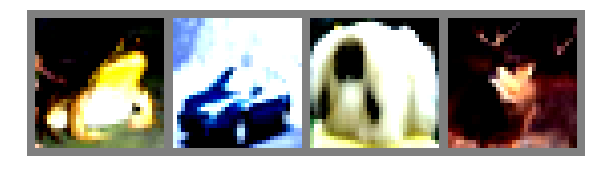

['frog', 'car', 'dog', 'deer']


In [7]:
plot_cifar10_pytorch()

In [8]:
num_classes

10

In [9]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

# Enkelt (gammeldags) nevralt nettverk (i et hypermoderne rammeverk)

<img src="assets/pytorch.png">

*Skyte spurv med kanoner*

In [10]:
input_size = 32*32*3
hidden_size = 84

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # Gjør bildet om til en lang 32*32*3 = 3072-vektor
        x = F.tanh(self.fc1(x)) # Kjør vektoren gjennom et hidden layer og en aktiveringsfunksjon
        x = self.fc2(x) # Prediker klassen ved å kjøre gjennom output-layer
        return x

*Kommenter at fc1 har output* `x = tanh(dot(W, x) + b)`

<img src="assets/tanh.gif">

*Trenger bare definere `forward`-funksjon. `backward` blir automatisk opprettet.*

In [12]:
net = Net(input_size = input_size, hidden_size = hidden_size, num_classes = num_classes)

In [13]:
net

Net(
  (fc1): Linear(in_features=3072, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
#list(net.parameters())
#len(list(net.parameters()))

**Trening**

Husk stegene:
1. Sett opp nevralt nettverk
2. Hent ut batch med treningsdata
3. Kjør disse gjennom nettverket for å få nettverkets prediksjoner
4. Mål avvik mellom fasit og prediskjon ved hjelp av loss-funksjon
5. Oppdater vektene ved å bruke back-propagation etterfulgt av gradient descent

*Mat inn data i nettverket:*

In [15]:
i, data = next(enumerate(trainloader, 0))

In [16]:
i

0

In [17]:
inputs, labels = data

In [18]:
len(inputs)

4

In [19]:
len(labels)

4

In [20]:
inputs[0]


(0 ,.,.) = 
  0.6338  0.6725  0.7113  ...   0.3817  0.4011  0.4205
  0.6919  0.6919  0.6919  ...   0.4399  0.4593  0.4593
  0.6338  0.6531  0.6338  ...   0.4787  0.4981  0.4399
           ...             ⋱             ...          
  0.8276  0.7694  0.8470  ...   0.5950  0.5756  0.5562
  0.8276  0.8082  0.8858  ...   0.6144  0.5756  0.5562
  0.7501  0.7307  0.7694  ...   0.5368  0.4981  0.4787

(1 ,.,.) = 
  0.0794  0.1188  0.1384  ...  -0.2549 -0.2156 -0.1762
  0.1581  0.1384  0.1384  ...  -0.1959 -0.1369 -0.1369
  0.1384  0.0991  0.0401  ...  -0.1369 -0.0976 -0.1369
           ...             ⋱             ...          
  0.2958  0.2368  0.2761  ...  -0.0189 -0.0386 -0.0582
  0.2564  0.2564  0.3154  ...  -0.0189 -0.0582 -0.0976
  0.1581  0.1581  0.1974  ...  -0.1172 -0.1369 -0.1762

(2 ,.,.) = 
 -0.1728 -0.1533 -0.1338  ...  -0.5825 -0.5435 -0.4850
 -0.0948 -0.1338 -0.1728  ...  -0.5630 -0.5045 -0.4850
 -0.1338 -0.1728 -0.2509  ...  -0.5045 -0.4655 -0.5045
           ...            

In [21]:
labels


 5
 5
 1
 0
[torch.LongTensor of size 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


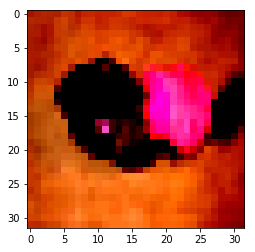

In [22]:
plt.imshow(np.transpose(torchvision.utils.make_grid(inputs[0]).numpy(), (1,2,0)))
plt.show()

In [23]:
classes[labels[0]]

'dog'

*Vi kan teste hvor godt vårt utrente nettverk med random vekter gjør det på de 10.000 testbildene. Forventer treffsikkerhet på 1/10:*

In [24]:
check_accuracy(net)

Accuracy til nettverket på de 10.000 testbildene: 13 %


*La oss mate bildene inn i nettverket. (Må wrappes i `Variable`.)*

In [25]:
inputs, labels = Variable(inputs), Variable(labels)

*Forward: Finner prediksjoner på bildene.*

In [26]:
outputs = net(inputs)

*Velg en loss-funksjon*

In [27]:
criterion = nn.CrossEntropyLoss()

*Regn ut loss:*

In [28]:
loss = criterion(outputs, labels)

In [29]:
loss

Variable containing:
 2.3962
[torch.FloatTensor of size 1]

*Backward: Finner alle vektenes bidrag til loss via backpropagation (automatisk derivasjon).*

In [30]:
loss.backward()

*Oppdaterer vektene ved å bruke SGD:*

`weight = weight - learning_rate * gradient`

In [31]:
learning_rate = 0.001

In [32]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

*Optimering: Bruker SGD til å modifisere alle vektene litt (med satt learning rate).*

In [33]:
optimizer.step()

*Nå har vi trent nettet bittelitt. Tester accuracy på nytt:*

In [34]:
check_accuracy(net)

Accuracy til nettverket på de 10.000 testbildene: 13 %


*Gjentar prosessen med neste batch av 4 bilder:*

In [35]:
i, data = next(enumerate(trainloader, 0))
inputs, labels = data
inputs, labels = Variable(inputs), Variable(labels)

*Må nulle ut gradientene mellom hver gang, ellers akkumuleres de:*

In [36]:
optimizer.zero_grad()

In [37]:
outputs = net(inputs)

In [38]:
loss = criterion(outputs, labels)

In [39]:
loss

Variable containing:
 2.1178
[torch.FloatTensor of size 1]

In [40]:
loss.backward()

In [41]:
optimizer.step()

In [42]:
check_accuracy(net)

Accuracy til nettverket på de 10.000 testbildene: 13 %


*Kan gjøre dette om og om igjen:*

In [43]:
i, data = next(enumerate(trainloader, 0))
inputs, labels = data
inputs, labels = Variable(inputs), Variable(labels)
optimizer.zero_grad()
outputs = net(inputs)
loss = criterion(outputs, labels)
print(f"Loss: {loss}")
loss.backward()
optimizer.step()
check_accuracy(net)

Loss: Variable containing:
 2.3306
[torch.FloatTensor of size 1]

Accuracy til nettverket på de 10.000 testbildene: 13 %


*Tungvint... Krever mange manuelle gjennomkjøringer.. Hvor mange? Antall bilder:*

In [44]:
len(trainloader.dataset)

50000

*Antall batches på 4 hver:*

In [45]:
len(trainloader.dataset)/4

12500.0

*Må kjøre blokken over 12500 ganger for å komme én gang gjennom treningsdata.. Bedre å lage en loop:*

In [46]:
# Antall ganger gjennom hele treningsdatasettet
num_epochs = 2

In [61]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print hver 2000-ende batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            check_accuracy(net)
            running_loss = 0.0

print('Ferdig')

[1,  2000] loss: 1.948
Accuracy til nettverket på de 10.000 testbildene: 36 %
[1,  4000] loss: 1.825
Accuracy til nettverket på de 10.000 testbildene: 37 %
[1,  6000] loss: 1.798
Accuracy til nettverket på de 10.000 testbildene: 39 %
[1,  8000] loss: 1.741
Accuracy til nettverket på de 10.000 testbildene: 40 %
[1, 10000] loss: 1.755
Accuracy til nettverket på de 10.000 testbildene: 40 %
[1, 12000] loss: 1.724
Accuracy til nettverket på de 10.000 testbildene: 41 %
[2,  2000] loss: 1.666
Accuracy til nettverket på de 10.000 testbildene: 42 %
[2,  4000] loss: 1.687
Accuracy til nettverket på de 10.000 testbildene: 42 %
[2,  6000] loss: 1.661
Accuracy til nettverket på de 10.000 testbildene: 42 %
[2,  8000] loss: 1.670
Accuracy til nettverket på de 10.000 testbildene: 42 %
[2, 10000] loss: 1.651
Accuracy til nettverket på de 10.000 testbildene: 42 %
[2, 12000] loss: 1.645
Accuracy til nettverket på de 10.000 testbildene: 43 %
Ferdig


<img src="assets/tommelopp.png">

# Samme nettverk i Keras (og på GPU)

<img src="assets/kerastf.png">

In [47]:
!nvidia-smi

Tue Apr 10 17:31:16 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0  On |                  N/A |
| 27%   55C    P8    24W / 250W |   1150MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [48]:
(x_train, y_train), (x_test, y_test) = get_cifar10_keras()

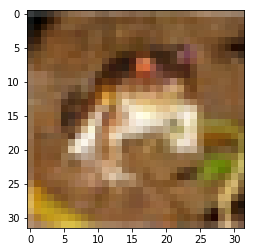

In [49]:
plt.imshow(x_train[0])
plt.show()

In [50]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Definer nettverket:

In [51]:
input_size = 32*32*3
hidden_size = 84

In [52]:
model = Sequential()

model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(hidden_size, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                258132    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                850       
Total params: 258,982
Trainable params: 258,982
Non-trainable params: 0
_________________________________________________________________


In [54]:
learning_rate = 0.001

In [55]:
opt = keras.optimizers.sgd(lr=learning_rate)

In [56]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [24]:
model.fit(x_train, y_train,
              batch_size=4,
              epochs=1,
              validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 30s 604us/step - loss: 1.7445 - acc: 0.3867 - val_loss: 1.7364 - val_acc: 0.3865


In [27]:
loss, acc = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 55us/step


In [28]:
loss, acc

(1.7363558891296387, 0.3865)

In [ ]:
model.fit(x_train, y_train,
              batch_size=4,
              epochs=5,
              validation_data=(x_test, y_test))

# Et moderne nettverk

In [57]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [58]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6) # 65% etter 2 epoker

In [59]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [88]:
model.fit(x_train, y_train,
              batch_size=4,
              epochs=2,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 69s 1ms/step - loss: 1.5567 - acc: 0.4357 - val_loss: 1.2885 - val_acc: 0.5385
Epoch 2/2
50000/50000 [==============================] - 70s 1ms/step - loss: 1.2429 - acc: 0.5638 - val_loss: 1.0829 - val_acc: 0.6211


*Forklar elementene i nettverket. Konvolusjoner, max-pooling, dropout etc*

*Vi kunne dratt inn mange triks for å booste dette. Data augmentation, ensembling, hyperparametertuning, etc. Men vi kan ikke dekke alt på 90 minutter! :-)*

# Et _hypermoderne_ nettverk

*DenseNet*

*Pre-trent på ImageNet*

In [60]:
batch_size=16

In [73]:
(x_train, y_train), (x_test, y_test) = get_data_dn121(allData=False)

Files already downloaded and verified
Files already downloaded and verified
Lastet inn data, konverterte til størrelse egnet for DenseNet121
allData=False, så kun 3000 treningseksempler ble lastet inn


In [74]:
model = densenet121_model()

/home/alex/Dropbox/Jobb/projects/ML/presentations/MediaCity-Fagkveld-apr2018/utils.py:287: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
/home/alex/anaconda2/envs/mediacity/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [75]:
#model.summary()

In [76]:
model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=1, shuffle=True,
          validation_data=(x_test, y_test),
          )

Train on 3000 samples, validate on 100 samples
Epoch 1/1
3000/3000 [==============================] - 62s 21ms/step - loss: 1.0947 - acc: 0.6240 - val_loss: 0.7675 - val_acc: 0.7200


*Ser lovende ut, selv med bare 3.000 treningsbilder! Men tar lang tid... Vi laster heller inn noe jeg har trent i noen timer (på en 1080Ti). Med alle 50.000 treningsbilder, 10 epoker. Ellers nøyaktig samme som over:*

In [77]:
(x_train, y_train), (x_test, y_test) = get_data_dn121(allData=True)

Files already downloaded and verified
Files already downloaded and verified
Lastet inn data, konverterte til størrelse egnet for DenseNet121


In [83]:
model = densenet121_pretrained()

/home/alex/Dropbox/Jobb/projects/ML/presentations/MediaCity-Fagkveld-apr2018/utils.py:288: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))
/home/alex/anaconda2/envs/mediacity/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [97]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 49s 5ms/step


[0.15310688046067952, 0.9525]

*Knuser altså resultatene over, og gjør Cifar10 omtrent ubrukelig som benchmark!*

# Mer interessant anvendelse

Gå til `2.0-medisinske-bilder.ipynb`

Men først: shut down

<img src="assets/shutdown.png">